# 🔍 Attention Mechanism 


Attention is a technique that allows a model to **focus on the most relevant parts** of the input when generating an output.  
It solves the limitations of fixed-length representations and improves sequence modeling tasks like translation, summarization, and language modeling.

---

## ⭐ Why Attention?

Traditional models (RNNs, LSTMs) compress the entire input sequence into a **single vector**, which becomes a bottleneck for long sequences.

Attention removes this bottleneck by allowing the model to **dynamically look at different parts of the input**, assigning each part a *weight* indicating its importance.

---

In this project, we study the evolution of attention from a very simple version to the full Transformer attention used in LLMs.  
These four types build on each other step by step.

---

# 1️⃣ Simplified Self-Attention (No Q, K, V Matrices)

This is the most basic form of attention.

- The input sequence **X** attends to itself.
- We directly compute a similarity score using:

$$[
A = \text{softmax}(X X^T)
]$$

Then the output is:

$$[
\text{Output} = A X
]$$

**Characteristics**
- No learnable projection matrices.
- Only uses dot products between tokens.
- Demonstrates the *idea* of weighting tokens by similarity.

---

# 2️⃣ Standard Self-Attention (With Q, K, V Projections)

This is the real attention mechanism used in Transformers.

We first compute:

$$[
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
]$$

Then:

$$[
\text{Attention}(Q,K,V) = 
\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
]$$

**Characteristics**
- Learnable weights: \(W_Q, W_K, W_V\)
- Handles interactions between all tokens.
- Fully differentiable → trained using gradient descent.

---

# 3️⃣ Causal Attention (Masking Future Tokens)

Used in **autoregressive** models like GPT.

We apply a **causal mask** so a token can only attend to **previous** and **current** positions:

$$
\text{mask}(i,j) = 
\begin{cases}
0 & \text{if } j \le i \\
-\infty & \text{if } j > i
\end{cases}
 $$

So:

$$[
\text{Attention}(Q,K,V) =
\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}} + \text{mask}\right)V
]$$

**Characteristics**
- Prevents “cheating”
- Needed for next-token prediction
- Keeps the model strictly left-to-right

---

# 4️⃣ Multi-Head Attention

Instead of one attention calculation, we run **multiple attention heads in parallel**.

Each head learns different relations:

$$[
\text{head}_i = \text{Attention}(QW_{Qi},\, KW_{Ki},\, VW_{Vi})
]$$

Then we concatenate:

$$[
\text{MHA}(X) = \text{Concat}(\text{head}_1, \ldots, \text{head}_h) W_O
]$$

**Characteristics**
- Multiple attention “perspectives”
- Captures different patterns (syntax, meaning, long-range relations)
- Final step before feed-forward layers in Transformers

---

# ✅ Summary Table

| Attention Type             | Description |
|---------------------------|-------------|
| **Simplified Self-Attention** | Basic version; no Q/K/V; demonstrates core idea |
| **Self-Attention**          | Full Q/K/V projections; core Transformer component |
| **Causal Attention**        | Adds mask to prevent attending to the future |
| **Multi-Head Attention**    | Multiple parallel attentions combined |

---

# 🎯 Why It Matters

Attention allowed models to:
- Capture long-range dependencies
- Parallelize computation
- Replace RNNs entirely
- Build powerful LLMs like GPT-3/4/5




## 1️⃣ Simplified Self-Attention (No Q, K, V Matrices)

In [1]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

<div >

Consider the following input sentence, which has already been embedded into 3-
dimensional vectors. 

We choose a small embedding dimension for
illustration purposes to ensure it fits on the page without line breaks:

</div>

In [2]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

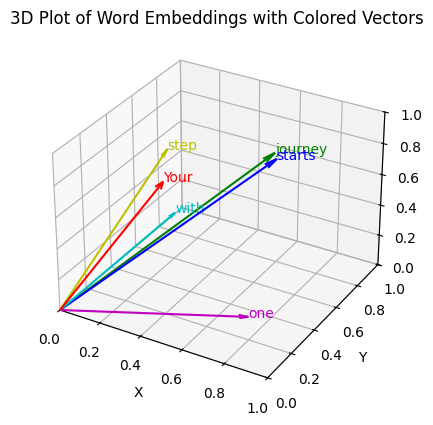

In [3]:
# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# Create 3D plot with vectors from origin to each point, using different colors
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Define a list of colors for the vectors
colors = ['r', 'g', 'b', 'c', 'm', 'y']

# Plot each vector with a different color and annotate with the corresponding word
for (x, y, z, word, color) in zip(x_coords, y_coords, z_coords, words, colors):
    # Draw vector from origin to the point (x, y, z) with specified color and smaller arrow length ratio
    ax.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax.text(x, y, z, word, fontsize=10, color=color)

# Set labels for axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Set plot limits to keep arrows within the plot boundaries
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_zlim([0, 1])

plt.title('3D Plot of Word Embeddings with Colored Vectors')
plt.show()


## Simple Self-Attention Using Word Embeddings

we already have the **vector embeddings** for each input word in the sentence:

Each vector `vi` is the numerical embedding of a word.

---

### Step 1: Choose the Query Word

We choose the **second word "journey"** as the **Query**:

This means we want to know:
**How much does "journey" attend to the other words?**

---

### Step 2: Compute Attention Scores Using Dot Product

We calculate the dot product between the query and all input vectors:

Each `score` represents the **similarity between "journey" and every word**.





In [4]:
query = inputs[1]  # 2nd input token is the query

attn_scores_2 = torch.empty(inputs.shape[0])
for i, x_i in enumerate(inputs):
    attn_scores_2[i] = torch.dot(x_i, query)# dot product (transpose not necessary here since they are 1-dim vectors)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


**As we can see `'journey' is close to 'journey','starts','step'`  and far from `'one'`**

### Attention Score Normalization

The main goal of the **normalization step** is to convert raw attention scores into **attention weights that sum up to 1**.  

This normalization is important for two main reasons:

1. **Interpretability**  
   It allows us to interpret each attention value as a **probability** that reflects how important each input token is.

2. **Training Stability**  
   Normalization helps maintain **numerical stability during training**, which is critical for large language models (LLMs).

---

## How the Normalization is Applied

After computing the raw attention scores using the dot product, we **normalize each score using Softmax**:

- This converts arbitrary real-valued scores into values between **0 and 1**
- The total sum of all attention weights becomes exactly **1**

This step ensures that each token contributes proportionally to the final attention output.

---


In [5]:
sum_values = attn_scores_2.sum()
normalized_values = attn_scores_2/sum_values

print("Attention weights:", normalized_values)
print("Sum:", normalized_values.sum())

Attention weights: tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])
Sum: tensor(1.0000)


**In practice, it's more common and advisable to use the softmax function for normalization.
This approach is better at managing extreme values and offers more favorable gradient properties during training.** 

`Below is a basic implementation of the softmax function for normalizing the attention scores`

In [6]:
def basic_softmax(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

print("Attention weights:", basic_softmax(attn_scores_2))
print("Sum:", basic_softmax(attn_scores_2).sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


Note that this naive softmax implementation (basic_softmax) may encounter numerical
instability problems, such as overflow and underflow, when dealing with large or small input
values. 

Therefore, in practice, it's advisable to use the PyTorch implementation of softmax,
which has been extensively optimized for performance:

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2 , dim=0)

print("Attention weights:", attn_weights_2)
print("Sum:", attn_weights_2.sum())

Attention weights: tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])
Sum: tensor(1.)


**The context vector z(2)is calculated as a weighted sum of all input
vectors.** 

`This involves multiplying each input vector by its corresponding attention weight`

In [8]:
query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i

print(context_vec_2)

tensor([0.4419, 0.6515, 0.5683])


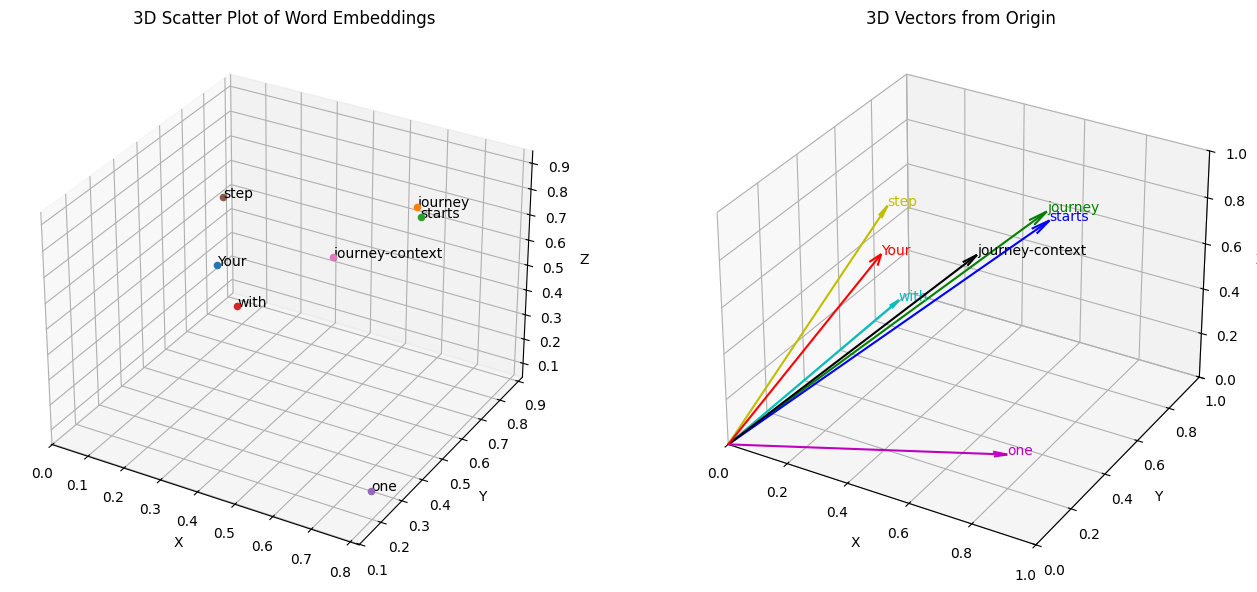

In [9]:
context_vec_2 = context_vec_2.squeeze()
context_vec_2 = context_vec_2.unsqueeze(0)
inputs = torch.cat((inputs, context_vec_2), dim=0)

# Corresponding words
words = ['Your', 'journey', 'starts', 'with', 'one', 'step', 'journey-context']

# Extract x, y, z coordinates
x_coords = inputs[:, 0].numpy()
y_coords = inputs[:, 1].numpy()
z_coords = inputs[:, 2].numpy()

# ---------- CREATE SIDE-BY-SIDE SUBPLOTS ----------
fig = plt.figure(figsize=(14, 6))

# ========== LEFT PLOT: SCATTER ==========
ax1 = fig.add_subplot(121, projection='3d')

for x, y, z, word in zip(x_coords, y_coords, z_coords, words):
    ax1.scatter(x, y, z)
    ax1.text(x, y, z, word, fontsize=10)

ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_title('3D Scatter Plot of Word Embeddings')

# ========== RIGHT PLOT: VECTORS ==========
ax2 = fig.add_subplot(122, projection='3d')

colors = ['r', 'g', 'b', 'c', 'm', 'y', 'k']

for x, y, z, word, color in zip(x_coords, y_coords, z_coords, words, colors):
    ax2.quiver(0, 0, 0, x, y, z, color=color, arrow_length_ratio=0.05)
    ax2.text(x, y, z, word, fontsize=10, color=color)

ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')

ax2.set_xlim([0, 1])
ax2.set_ylim([0, 1])
ax2.set_zlim([0, 1])

ax2.set_title('3D Vectors from Origin')

plt.tight_layout()
plt.show()


**Now, we can extend this computation to calculate attention weights and context vectors for all inputs.**

In [10]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

att_scores_matrix =torch.empty(6 ,6) 

for i,x_i in enumerate(inputs):
    for j , x_j in enumerate(inputs):
        att_scores_matrix[i,j]=torch.dot(x_i,x_j)
att_scores_matrix

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])

**we could get same result in faster way by using matrix multiplications**

In [11]:
attn_scores = inputs @ inputs.T
print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


**so nw we need the attention weights**

In [12]:
attn_weights = torch.softmax(attn_scores, dim=-1) # dim=-1 to normalize across the columns
attn_weights

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])

In [13]:
#to make sure that we normalized right 
print(attn_weights.sum(dim=-1))

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])


**In the third and last step, we now use these attention weights to compute all context
vectors via matrix multiplication:**

In [14]:
context_matrix = attn_weights @ inputs
context_matrix

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])

In [15]:
# to make sure we are right 
print("the clculated context vector for journey  : ",context_vec_2)
print("the index 1 whitch represent word journey : ",context_matrix[1])

the clculated context vector for journey  :  tensor([[0.4419, 0.6515, 0.5683]])
the index 1 whitch represent word journey :  tensor([0.4419, 0.6515, 0.5683])


## 2️⃣ Standard Self-Attention (With Q, K, V Projections)

In [16]:
inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

We first compute:

$$[
Q = XW_Q,\quad K = XW_K,\quad V = XW_V
]$$

In [17]:
# lets intialize the W_q, W_k, W_v matrices
x_2 = inputs[1]   #will store journy vector 
m = inputs.shape[1] # should the same dim as inputs columns
n = 2  # could be any number it represtnt the dimension of the vectors after projection 

# now create the matrices 
torch.manual_seed(123)
W_query = torch.nn.Parameter(torch.rand(m, n), requires_grad=False) #intalize random weights for the training
W_key = torch.nn.Parameter(torch.rand(m, n), requires_grad=False)
W_value = torch.nn.Parameter(torch.rand(m, n), requires_grad=False)

**Note that in GPT-like models, the input and output dimensions are usually the same.** 

But for illustration purposes, to better follow the computation, we choose different input (d_in=3)
and output (d_out=2) dimensions here.

**Note that we are setting requires_grad=False to reduce clutter in the outputs for
illustration purposes.** 
If we were to use the weight matrices for model training, we
would set requires_grad=True to update these matrices during model training.

In [18]:
print(W_query)  #W_key W_value are similar

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [19]:
print(W_query)  #W_key W_value are similar

Parameter containing:
tensor([[0.2961, 0.5166],
        [0.2517, 0.6886],
        [0.0740, 0.8665]])


In [20]:
# lets calculate the query , key value vectors for the journey 
q_2 = x_2 @ W_query
k_2 = x_2 @ W_key
v_2 = x_2 @ W_value
print(q_2) # became 2d 

tensor([0.4306, 1.4551])


**We can obtain all quires, keys and values via matrix multiplication:**

In [21]:
querys = inputs @ W_query
keys   = inputs @ W_key
values = inputs @ W_value
print("Queres.shape:", querys.shape)
print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

Queres.shape: torch.Size([6, 2])
keys.shape: torch.Size([6, 2])
values.shape: torch.Size([6, 2])


**As we can tell from the outputs, we successfully projected the 6 input tokens from a 3D
onto a 2D embedding space:**

second compute:

$$[
attention scores = QK^T  
]$$

**First, let's compute the attention score ω22**

In [22]:
keys_2 = keys[1]
w22 = q_2.dot(keys_2)
w22

tensor(1.8524)

**to genralize to calculate all scores for "journey"**

In [23]:
atten_scores_2 = q_2 @ keys.T # All attention scores for given query
atten_scores_2

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])

In [24]:
#so all atention scores will be 
atten_scores = querys @ keys.T
atten_scores

tensor([[0.9231, 1.3545, 1.3241, 0.7910, 0.4032, 1.1330],
        [1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440],
        [1.2544, 1.8284, 1.7877, 1.0654, 0.5508, 1.5238],
        [0.6973, 1.0167, 0.9941, 0.5925, 0.3061, 0.8475],
        [0.6114, 0.8819, 0.8626, 0.5121, 0.2707, 0.7307],
        [0.8995, 1.3165, 1.2871, 0.7682, 0.3937, 1.0996]])

Third compute:

$$[
Attention Weights = {softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)
]$$
where d_k is the dimensions of keys matrics in our example >>2d

**then We compute the attention weights by scaling the
attention scores and using the softmax function we used earlier.** 

The difference to earlier is
that we now scale the attention scores by dividing them by the square root of the
embedding dimension of the keys. 

Note that taking the square root is mathematically the same as exponentiating by 0.5:

In [25]:
#attention weights for journey 
d_k= keys.shape[1]
atten_weights_2 = torch.softmax(atten_scores_2/(d_k**0.5) , dim=-1)
atten_weights_2

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])

**We divide by √dₖ to prevent the dot-product values from getting too large as the dimension grows, keeping the softmax stable and training smooth.**
- Without scaling → attention logits too large → softmax outputs “0 or 1”.

- With scaling → logits moderate → softmax spreads attention normally.

**also the dot product variance increases linearly → values get larger.
To keep the variance around 1, we divide by: √dₖ**


In [26]:
# why we devide by sqrt(d_k)
atten_weights_2_with = torch.softmax(atten_scores_2/(d_k**0.5) , dim=-1)
atten_weights_2_without = torch.softmax(4*atten_scores_2 , dim=-1) # make values larger for illustration

print("atten weights with scaling" , atten_weights_2_with)
print("atten weights without scaling" , atten_weights_2_without)

print("variance before scalling " , torch.var(atten_weights_2_without))
print("variance after scalling " , torch.var(atten_weights_2_with)) # the  diff in variance for larger dim will be more clear 

atten weights with scaling tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])
atten weights without scaling tensor([0.0426, 0.4371, 0.3706, 0.0199, 0.0025, 0.1273])
variance before scalling  tensor(0.0360)
variance after scalling  tensor(0.0028)


Last step compute:
**multiply the attention weights by tne values matrix**
$$[
\text{Attention}(Q,K,V) = 
\text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
]$$

In [27]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3069, 0.8188])


### IMPLEMENTING A COMPACT SELF ATTENTION PYTHON CLASS
**to represent the whole process of self attention**

In [28]:
import torch.nn as nn
class SelfAttention_V1(nn.Module):
    def __init__(self, d_in, d_out):
        super().__init__()
        self.W_query = nn.Parameter(torch.rand(d_in,d_out))
        self.W_key   = nn.Parameter(torch.rand(d_in,d_out))
        self.W_value = nn.Parameter(torch.rand(d_in,d_out))

    def forward (self,X):
        querys = X @ self.W_query 
        keys   = X @ self.W_key
        values = X @ self.W_value 

        atten_scores  = querys @ keys.T
        scaled_scores = atten_scores / (keys.shape[-1]**0.5)
        atten_weights = torch.softmax(scaled_scores,dim=-1)

        context_vecor = atten_weights @ values
        return context_vecor

**In this PyTorch code, SelfAttention_v1 is a class derived from nn.Module, which is a
fundamental building block of PyTorch models, which provides necessary functionalities for
model layer creation and management.**  

In [29]:
torch.manual_seed(123)
d_in=3
d_out=2
context_vector = SelfAttention_V1(d_in=d_in,d_out=d_out)
context_vector(inputs)

tensor([[0.2996, 0.8053],
        [0.3061, 0.8210],
        [0.3058, 0.8203],
        [0.2948, 0.7939],
        [0.2927, 0.7891],
        [0.2990, 0.8040]], grad_fn=<MmBackward0>)

**We can improve the SelfAttention_v1 implementation further by utilizing PyTorch's
`nn.Linear` layers, which effectively perform matrix multiplication when the bias units are
disabled.**
- Additionally, a significant advantage of using `nn.Linear` instead of manually
implementing nn.Parameter(torch.rand(...)) is that `nn.Linear has an optimized weight
initialization scheme`, contributing to more stable and effective model training.

In [30]:
class SelfAttention_V2(nn.Module):
    def __init__(self, d_in , d_out ,qkv_bias=False):
        super().__init__()
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)

    def forward(self, X):
        querys = self.W_query(X)
        keys   = self.W_key(X)
        values = self.W_value(X) 

        atten_scores  = querys @ keys.T
        scaled_scores = atten_scores / (keys.shape[-1]**0.5)
        atten_weights = torch.softmax(scaled_scores,dim=-1)

        context_vecor = atten_weights @ values
        return context_vecor

In [31]:
torch.manual_seed(789)
context_vector = SelfAttention_V2(d_in, d_out)
print(context_vector(inputs))

tensor([[-0.0739,  0.0713],
        [-0.0748,  0.0703],
        [-0.0749,  0.0702],
        [-0.0760,  0.0685],
        [-0.0763,  0.0679],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)


**Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they
use different initial weights for the weight matrices since nn.Linear uses a more
sophisticated weight initialization scheme.**

## 3️⃣ Causal Attention (Masking Future Tokens)

**Let's work with the attention scores and weights from the previous section to code the causal attention mechanism.**
Reuse the query and key weight matrices of the SelfAttention_v2 object from the previous section for convenience

In [32]:
queries = context_vector.W_query(inputs) 
keys = context_vector.W_key(inputs)
attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[0.1921, 0.1646, 0.1652, 0.1550, 0.1721, 0.1510],
        [0.2041, 0.1659, 0.1662, 0.1496, 0.1665, 0.1477],
        [0.2036, 0.1659, 0.1662, 0.1498, 0.1664, 0.1480],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.1661, 0.1564],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.1585],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


**We can now use PyTorch's tril function to create a mask
where the values above the diagonal are zero:**

In [33]:
context_length = attn_weights.shape[0]
mask = torch.tril(torch.ones(context_length,context_length))
mask

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])

**Now, we can multiply this mask with the attention weights to zero out the values above the
diagonal:**

In [34]:
masked_atten = attn_weights * mask
masked_atten

tensor([[0.1921, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2041, 0.1659, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2036, 0.1659, 0.1662, 0.0000, 0.0000, 0.0000],
        [0.1869, 0.1667, 0.1668, 0.1571, 0.0000, 0.0000],
        [0.1830, 0.1669, 0.1670, 0.1588, 0.1658, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<MulBackward0>)

**The third step is to renormalize the attention weights to sum up to 1 again in
each row.** 
We can achieve this by dividing each element in each row by the sum in each
row:

In [35]:
row_sums = masked_atten.sum(dim=1, keepdim=True)
masked_atten_norm = masked_atten / row_sums
print(masked_atten_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<DivBackward0>)


#### this way is good but it will cause **`data leakage` .**

**While we could be technically done with implementing causal attention at this point, we can
take advantage of a mathematical property of the softmax function.** 
- We can implement the computation of the masked attention weights more efficiently in fewer steps.

- The softmax function converts its inputs into a probability distribution. 

- When negative infinity values (-∞) are present in a row, the softmax function treats them as zero probability. 
`(Mathematically, this is because e-∞ approaches 0.)`

- We can implement this more efficient masking "trick" by creating a mask with 1's above
the diagonal and then replacing these 1's with negative infinity (-inf) values:

In [36]:
# create the mask with ones in upper tringular 
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
#then replace this ones with -∞ and zeros withe the attention scores
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.2899,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.4656, 0.1723,   -inf,   -inf,   -inf,   -inf],
        [0.4594, 0.1703, 0.1731,   -inf,   -inf,   -inf],
        [0.2642, 0.1024, 0.1036, 0.0186,   -inf,   -inf],
        [0.2183, 0.0874, 0.0882, 0.0177, 0.0786,   -inf],
        [0.3408, 0.1270, 0.1290, 0.0198, 0.1290, 0.0078]],
       grad_fn=<MaskedFillBackward0>)


**Now, all we need to do is apply the softmax function to these masked results, and we are
done.**

In [37]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5517, 0.4483, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3800, 0.3097, 0.3103, 0.0000, 0.0000, 0.0000],
        [0.2758, 0.2460, 0.2462, 0.2319, 0.0000, 0.0000],
        [0.2175, 0.1983, 0.1984, 0.1888, 0.1971, 0.0000],
        [0.1935, 0.1663, 0.1666, 0.1542, 0.1666, 0.1529]],
       grad_fn=<SoftmaxBackward0>)


**Masking in Transformers sets scores for future tokens to a large negative value, making their influence in the softmax calculation effectively zero.**

- The softmax function then recalculates attention weights only among the unmasked tokens.

- This process ensures no information leakage from masked tokens, focusing the model solely on the intended data.

In [38]:
causal_context = attn_weights @ context_vector.W_value(inputs)
causal_context

tensor([[-0.0872,  0.0286],
        [-0.0991,  0.0501],
        [-0.0999,  0.0633],
        [-0.0983,  0.0489],
        [-0.0514,  0.1098],
        [-0.0754,  0.0693]], grad_fn=<MmBackward0>)

**in the next section,we first cover another minor tweak to the causal attention mechanism that is useful for
reducing overfitting when training LLMs**

### MASKING ADDITIONAL ATTENTION WEIGHTS WITH DROPOUT
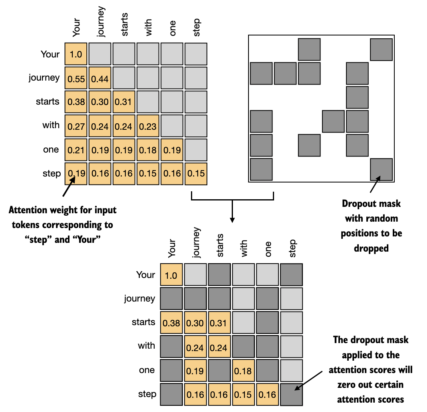

In [39]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5) # remove half of the values randomly just for illustration
example = torch.ones(6, 6) 
print(dropout(example))# the values with will not removed wil divided by 0.5 mean 1 became 2 

tensor([[2., 2., 0., 2., 2., 0.],
        [0., 0., 0., 2., 0., 2.],
        [2., 2., 2., 2., 0., 2.],
        [0., 2., 2., 0., 0., 2.],
        [0., 2., 0., 2., 0., 2.],
        [0., 2., 2., 2., 2., 0.]])


**When applying dropout to an attention weight matrix with a rate of 50%, half of the elements in the matrix are randomly set to zero.**

- To compensate for the reduction in active elements, the values of the remaining elements in the matrix are scaled up by a factor of 1/0.5 =2.

- This scaling is crucial to maintain the overall balance of the attention weights, ensuring that the average influence of the attention mechanism remains consistent during both the training and inference phases.

In [40]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.7599, 0.6194, 0.6206, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.4921, 0.4925, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3966, 0.0000, 0.3775, 0.0000, 0.0000],
        [0.0000, 0.3327, 0.3331, 0.3084, 0.3331, 0.0000]],
       grad_fn=<MulBackward0>)


### IMPLEMENTING A COMPACT CAUSAL ATTENTION CLASS

**Before we begin, one more thing is to ensure that the code can handle batches consisting of more than one input.**

This will ensure that the CausalAttention class supports the batch outputs produced by the data loader we implemented earlier.

 **2 inputs with 6 tokens each, and each token has embedding dimension 3**

In [41]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape) 

torch.Size([2, 6, 3])


- Step 1: Compared to the previous SelfAttention_v2 class, we added a dropout layer.
    
- Step 2: The register_buffer call is also a new addition (more information is provided in the following text).

- Step 3:  We transpose dimensions 1 and 2, keeping the batch dimension at the first position (0).

- Step 4: In PyTorch, operations with a trailing underscore are performed in-place, avoiding unnecessary memory
copies

In [42]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout) # New
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape # New batch dimension b because x is 3d now 
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)  

        attn_scores = queries @ keys.transpose(1, 2) # Changed transpose to transpose the tokens and its vectors only 
        attn_scores.masked_fill_(  # New, _ ops are in-place
        self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)  # `:num_tokens` to account for cases where the number of tokens in the batch is smaller than the supported context_size

        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights) # New

        context_vec = attn_weights @ values
        return context_vec

**The use of register_buffer in PyTorch is not strictly necessary for all use cases but offers several advantages here.** 

- For instance, when we use the CausalAttention class in our LLM, buffers are automatically moved to the appropriate device (CPU or GPU) along with our model, which will be relevant
- This means we don't need to manually ensurethese tensors are on the same device as your model parameters, avoiding device mismatch
errors.

In [43]:
torch.manual_seed(123)
context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)
context_vecs = ca(batch)
print("context_vecs.shape:", context_vecs.shape)
context_vecs

context_vecs.shape: torch.Size([2, 6, 2])


tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)

## 4️⃣ Multi-Head Attention

**In practical terms, implementing multi-head attention involves creating multiple instances of the self-attention mechanism, each with its own weights, and then combining their outputs**
- In code, we can achieve this by implementing a simple MultiHeadAttentionWrapper class that stacks multiple instances of our previously implemented CausalAttention module:

In [44]:
class MultiHeadAttentionWrapper(nn.Module):

    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        self.heads = nn.ModuleList(
            [CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) 
             for _ in range(num_heads)]
        )

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim=-1)

**To illustrate further with a concrete example, we can use the MultiHeadAttentionWrapper class similar to the CausalAttention class before**
- For example, if we use this MultiHeadAttentionWrapper class with two attention heads (via num_heads=2) and CausalAttention output dimension d_out=2, this results in a 4- dimensional context vectors (d_out*num_heads=4)

In [45]:
torch.manual_seed(123)
context_length = batch.shape[1] # This is the number of tokens
d_in, d_out = 3, 2
mha = MultiHeadAttentionWrapper(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)
context_vecs.shape: torch.Size([2, 6, 4])


**The first dimension of the resulting context_vecs tensor is 2 since we have two input texts (the input texts are duplicated, which is why the context vectors are exactly the same for those).**

The second dimension refers to the 6 tokens in each input. The third dimension refers to the 4-dimensional embedding of each token.

**we implemented a MultiHeadAttentionWrapper that combined multiple single-head attention modules.
However, note that these are processed sequentially via [head(x) for head in self.heads] in the forward method.**

- `We can improve this implementation by processing the heads in parallel.`

## > IMPLEMENTING MULTI-HEAD ATTENTION WITH WEIGHT SPLITS

**In the MultiHeadAttentionWrapper, multiple heads are implemented by creating a list of CausalAttention objects (self.heads), each representing a separate attention head.**

- The CausalAttention class independently performs the attention mechanism, and the results from each head are concatenated.

- In contrast, the following MultiHeadAttention class integrates the multi-head functionality within a single class.

- It splits the input into multiple heads by reshaping the projected query, key, and value tensors and then combines the results from these heads after computing attention.

In [46]:
class MultiHeadAttention(nn.Module):
    def __init__(self,d_in,d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"
       # intial values 
        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        # intialize the weight matrices 
        self.W_K = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_Q = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_V = nn.Linear(d_in, d_out, bias=qkv_bias)

        # to applay the mask of causal attention
        self.register_buffer("mask",torch.triu(torch.ones(context_length, context_length),diagonal=1))
        # to applay dropout 
        self.dropout = nn.Dropout(dropout)

        # this is like a mixer to mix the weights from the heads together 
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
    def forward(self,x):
        b, num_tokens, d_in = x.shape

        keys = self.W_K(x) # Shape: (batch, num_tokens, d_out)
        queries = self.W_Q(x)
        values = self.W_V(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        # calculate the attention weights 
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        # dropout to enhance training 
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim) >> to get d_out 
        context_vec = (attn_weights @ values).transpose(1, 2) 

        # Combine heads, where self.d_out = self.num_heads * self.head_dim >> final context vector for each word 
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        # the mixer will mex the result of each head with other to consider all relations that each head collect
        context_vec = self.out_proj(context_vec) 


        return context_vec

**to sum up this class steps**
- Step 1: Reduce the projection dim to match desired output dim

- Step 2: Use a Linear layer to combine head outputs

- Step 3: Tensor shape: (b, num_tokens, d_out)

- Step 4: We implicitly split the matrix by adding a num_heads dimension. Then we unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)

- Step 5: Transpose from shape (b, num_tokens, num_heads, head_dim) to (b, num_heads, num_tokens, head_dim)

- Step 6: Compute dot product for each head

- Step 7: Mask truncated to the number of tokens

- Step 8: Use the mask to fill attention scores

- Step 9: Tensor shape: (b, num_tokens, n_heads, head_dim)

- Step 10: Combine heads, where self.d_out = self.num_heads * self.head_dim

- Step 11: Add linear projection to mix the result of each head 

**To illustrate this batched matrix multiplication, suppose we have the following example
tensor:**

In [47]:
#The shape of this tensor is (b, num_heads, num_tokens, head_dim) = (1, 2, 3, 4)
a = torch.tensor([[[[0.2745, 0.6584, 0.2775, 0.8573], #A
[0.8993, 0.0390, 0.9268, 0.7388],
[0.7179, 0.7058, 0.9156, 0.4340]],
[[0.0772, 0.3565, 0.1479, 0.5331],
[0.4066, 0.2318, 0.4545, 0.9737],
[0.4606, 0.5159, 0.4220, 0.5786]]]])

In [48]:
#Now, we perform a batched matrix multiplication between the tensor itself and a view of
#the tensor where we transposed the last two dimensions, num_tokens and head_dim:
print(a @ a.transpose(2, 3))

tensor([[[[1.3208, 1.1631, 1.2879],
          [1.1631, 2.2150, 1.8424],
          [1.2879, 1.8424, 2.0402]],

         [[0.4391, 0.7003, 0.5903],
          [0.7003, 1.3737, 1.0620],
          [0.5903, 1.0620, 0.9912]]]])


In [49]:
# In this case, the matrix multiplication implementation in PyTorch handles the 4-dimensional input tensor so that the matrix multiplication
# is carried out between the 2 last dimensions (num_tokens, head_dim) and then repeated for the individual heads.
first_head = a[0, 0, :, :]
first_res = first_head @ first_head.T
print("First head:\n", first_res)
second_head = a[0, 1, :, :]
second_res = second_head @ second_head.T
print("\nSecond head:\n", second_res)

First head:
 tensor([[1.3208, 1.1631, 1.2879],
        [1.1631, 2.2150, 1.8424],
        [1.2879, 1.8424, 2.0402]])

Second head:
 tensor([[0.4391, 0.7003, 0.5903],
        [0.7003, 1.3737, 1.0620],
        [0.5903, 1.0620, 0.9912]])


### last example (multi head )

In [50]:
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [54]:
#The MultiHeadAttention class can be used similar to the SelfAttention and CausalAttention classes we implemented earlier:
torch.manual_seed(123)
batch_size, context_length, d_in = batch.shape
d_out = 6
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)
context_vecs = mha(batch)
print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[-0.2348,  0.0860,  0.4357,  0.5170, -0.1946,  0.4253],
         [-0.2989,  0.0016,  0.4063,  0.5694, -0.1502,  0.4053],
         [-0.3222, -0.0265,  0.3980,  0.5873, -0.1339,  0.3989],
         [-0.3342, -0.0029,  0.3569,  0.5603, -0.1294,  0.3546],
         [-0.3351,  0.0281,  0.3551,  0.5425, -0.1244,  0.3447],
         [-0.3415,  0.0243,  0.3344,  0.5368, -0.1246,  0.3263]],

        [[-0.2348,  0.0860,  0.4357,  0.5170, -0.1946,  0.4253],
         [-0.2989,  0.0016,  0.4063,  0.5694, -0.1502,  0.4053],
         [-0.3222, -0.0265,  0.3980,  0.5873, -0.1339,  0.3989],
         [-0.3342, -0.0029,  0.3569,  0.5603, -0.1294,  0.3546],
         [-0.3351,  0.0281,  0.3551,  0.5425, -0.1244,  0.3447],
         [-0.3415,  0.0243,  0.3344,  0.5368, -0.1246,  0.3263]]],
       grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 6])


**As we can see based on the results, the output dimension is directly controlled by the d_out argument:**